# Calibrating CRC incidence curves for LS population
Using available data to calibrated the incidence curves for colorectal cancer (CRC) in the LS population. These curves will be used as calibration targets in the state-transition model.

### Notebook configuration

In [17]:
import sys
import os

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

PARENT_DIR = "/Users/sophiewagner/repos/lynch-syndrome"
DATA_DIR = os.path.join(PARENT_DIR, "data")

In [19]:
genes = ['MLH1', 'MSH2', 'MSH6', 'PMS2']
sexes = ['male', 'female']

### Data loading

In [20]:
file_path = os.path.join(DATA_DIR, "crc_incidence.xlsx")
dominguez = pd.read_excel(file_path, sheet_name="dominguez_2023")
nccn = pd.read_excel(file_path, sheet_name="NCCN")

In [21]:
# Extract data from sheet

columns = dominguez.iloc[12,1:-3]
data = dominguez.iloc[13:61,1:-3].reset_index(drop=True)
data.columns = columns
data.columns.name = 'data'
data['age'] = pd.to_numeric(data['age'], errors='coerce')
data['lower'] = pd.to_numeric(data['lower'], errors='coerce')
data['upper'] = pd.to_numeric(data['upper'], errors='coerce')

# --------

columns = nccn.iloc[0,1:6]
data_nccn = nccn.iloc[1:5,1:6].reset_index(drop=True)
data_wang = nccn.iloc[8:14,1:6].reset_index(drop=True)
data_med_age = nccn.iloc[17:22, 1:6].reset_index(drop=True)
data_nccn.columns = data_wang.columns = data_med_age.columns = columns
data_nccn.columns.name = data_wang.columns.name = data_med_age.columns.name = 'data'

In [22]:
# Peek at data
print(data.head())
print("-" * 20)
print(data_nccn.head())
print("-" * 20)
print(data_wang)
print("-" * 20)
print(data_med_age)

data  gene  age     sex value  lower  upper
0     MLH1   30  Female     0    NaN    NaN
1     MLH1   40  Female     9    6.3   12.8
2     MLH1   50  Female  18.2   14.5   22.8
3     MLH1   60  Female  30.6   25.8   36.1
4     MLH1   70  Female  42.1   36.2   48.6
--------------------
data  gene  sex value lower upper
0     MLH1  all   NaN    46    61
1     MSH2  all   NaN    33    52
2     MSH6  all   NaN    10    44
3     PMS2  all   NaN   8.7    20
--------------------
data  gene     sex value lower upper
0     MLH1    male  43.9  39.6  46.6
1     MSH2    male  53.9    49  56.3
2     MSH6    male    12   2.4  24.6
3     MLH1  female  37.3  32.2  40.2
4     MSH2  female  38.6  34.1    42
5     MSH6  female  12.3   3.5  23.2
--------------------
data  gene  sex value lower upper
0     MLH1  all    44   NaN   NaN
1     MSH2  all    44   NaN   NaN
2     MSH6  all   NaN    42    69
3     PMS2  all   NaN    61    66


* **data** : dominguez_2023 data from Dominguez et al. 2023, contains cumulative CRC incidence (%) by age, sex, gene
* **data_nccn** : data from NCCN guidelines, contains CRC cumulative risk to age 70 by gene 
* **data_wang** : data from Wang et al. 2019, contains CRC cumulative risk to age 80 by sex, gene (not avail for PMS2)
* **data_med_age** : data from NCCN guidelines, contains median age of CRC diagnosis by gene

Data cleaning

In [ ]:
# Fill median age value with average of upper and lower where appropriate
data_med_age['value'] = data_med_age['value'].fillna(
    (data_med_age['lower'] + data_med_age['upper']) / 2
).infer_objects(copy=False)

# Cast sex to lowercase for consistent use
data['sex'] = data['sex'].str.lower()

# Fill in missing NCCN point estimate as midpoint
data_nccn['value'] = data_nccn['value'].fillna(
    (data_nccn['lower'] + data_nccn['upper']) / 2
).infer_objects(copy=False)

# Get male/female values from Wang
male_vals = data_wang.loc[data_wang['sex'] == 'male', 'value'].reset_index(drop=True)
female_vals = data_wang.loc[data_wang['sex'] == 'female', 'value'].reset_index(drop=True)

# Calculate sex ratios
male_to_female_ratio = (male_vals / female_vals).mean()
male_to_avg_ratio = (male_vals / ((male_vals + female_vals) / 2)).mean()
female_to_avg_ratio = (female_vals / ((male_vals + female_vals) / 2)).mean()

# Print ratios (optional)
print("Male to Female Ratio:", male_to_female_ratio)
print("Male to Avg Ratio:", male_to_avg_ratio)
print("Female to Avg Ratio:", female_to_avg_ratio)

# Estimate uncertainty range: use average relative error from Wang
wang_data = data_wang.copy()
wang_data['rel_lower'] = (wang_data['value'] - wang_data['lower']) / wang_data['value']
wang_data['rel_upper'] = (wang_data['upper'] - wang_data['value']) / wang_data['value']
avg_rel_lower = wang_data['rel_lower'].mean()
avg_rel_upper = wang_data['rel_upper'].mean()

# Grab NCCN PMS2 overall value
pms2_overall_val = data_nccn.loc[data_nccn['gene'] == 'PMS2', 'value'].iloc[0]

# Estimate sex-specific values using avg ratios
pms2_m_val = pms2_overall_val * male_to_avg_ratio
pms2_f_val = pms2_overall_val * female_to_avg_ratio

# Build new rows
row_pms2_m = {
    'gene': 'PMS2',
    'sex': 'male',
    'value': pms2_m_val,
    'lower': pms2_m_val * (1 - avg_rel_lower),
    'upper': pms2_m_val * (1 + avg_rel_upper)
}

row_pms2_f = {
    'gene': 'PMS2',
    'sex': 'female',
    'value': pms2_f_val,
    'lower': pms2_f_val * (1 - avg_rel_lower),
    'upper': pms2_f_val * (1 + avg_rel_upper)
}

# Append to data_wang
data_wang = pd.concat([data_wang, pd.DataFrame([row_pms2_m, row_pms2_f])], ignore_index=True)

Male to Female Ratio: 1.1829755042747612
Male to Avg Ratio: 1.0781135048567998
Female to Avg Ratio: 0.9218864951432001


/var/folders/m7/mpsrmwrn4qq669j2_9h94vjm0000gn/T/ipykernel_34708/1235593966.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_med_age['value'] = data_med_age['value'].fillna(
/var/folders/m7/mpsrmwrn4qq669j2_9h94vjm0000gn/T/ipykernel_34708/1235593966.py:10: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_nccn['value'] = data_nccn['value'].fillna(


In [24]:
# Print data after changes
print(data.head())
print("-" * 20)
print(data_nccn.head())
print("-" * 20)
print(data_wang)
print("-" * 20)
print(data_med_age)

data  gene  age     sex value  lower  upper
0     MLH1   30  female     0    NaN    NaN
1     MLH1   40  female     9    6.3   12.8
2     MLH1   50  female  18.2   14.5   22.8
3     MLH1   60  female  30.6   25.8   36.1
4     MLH1   70  female  42.1   36.2   48.6
--------------------
data  gene  sex  value lower upper
0     MLH1  all  53.50    46    61
1     MSH2  all  42.50    33    52
2     MSH6  all  27.00    10    44
3     PMS2  all  14.35   8.7    20
--------------------
   gene     sex      value     lower      upper
0  MLH1    male       43.9      39.6       46.6
1  MSH2    male       53.9        49       56.3
2  MSH6    male         12       2.4       24.6
3  MLH1  female       37.3      32.2       40.2
4  MSH2  female       38.6      34.1         42
5  MSH6  female       12.3       3.5       23.2
6  PMS2    male  15.470929  10.42324  21.164334
7  PMS2  female  13.229071  8.912832  18.097458
--------------------
data  gene  sex  value lower upper
0     MLH1  all   44.0   NaN   

# Interpolation and curve fitting

In [35]:
# Compute standard errors from 95% CI assuming normality
data['se'] = (data['upper'] - data['lower']) / (2 * 1.96)

# Fill in NAs
data2 = data.copy()
data2['se'] = np.where(data2['value'] == 0, data2['age']/10, data2['se'])
data2['value'] = np.where(data2['value'] == 0, data2['age']/20, data2['value'])

# Add anchor point at age 20
dummy_rows = pd.DataFrame([
    {
        'gene': gene,
        'sex': sex,
        'age': 20,            # Add at an age beyond your observed data
        'value': 0.5,         # Full cumulative risk
        'se': 1.0             # Arbitrary high uncertainty
    }
    for gene in genes
    for sex in sexes
])

# Append to original data2
data2 = pd.concat([data2, dummy_rows], ignore_index=True)
data2 = data2.sort_values(by=['gene','sex','age'])

data_med_age.loc[data_med_age['gene']=='MLH1',['lower','upper']] = [40, 60]
data_med_age.loc[data_med_age['gene']=='MSH2',['lower','upper']] = [40, 60]

In [40]:
def plot_logistic(sex, gene, age_l, age_u):
    # Define logistic function
    def logistic(x, L, k, x0):
        return L / (1 + np.exp(-k * (x - x0)))
    d_cumulative = data_wang.loc[(data_wang['sex']==sex) & (data_wang['gene']==gene)]
    d_by_age = data2.loc[(data2['sex']==sex) & (data2['gene']==gene)]
    d_med_age = data_med_age.loc[data_med_age['gene']==gene, 'value'].iloc[0]
    
    # Logistic function initial guesses: L, k, x0
    # L = max value, k = slope, x0 = inflection point
    p0 =[d_cumulative['value'].iloc[0], 0.15, d_med_age]
    lower = [d_cumulative['lower'].iloc[0]*0.75, 0.001, age_l]
    upper = [d_cumulative['upper'].iloc[0]*1.25, 1.0, age_u]
    bounds = (lower, upper)
    
    # Fit the curve
    age_fit = np.arange(20, 75)
    init_fit = logistic(age_fit, *p0)
    params, _ = curve_fit(logistic, d_by_age['age'], d_by_age['value'], sigma=d_by_age['se'], p0=p0, bounds=bounds, absolute_sigma=True)
    risk_fit = logistic(age_fit, *params)
    med_age=params[2]
    print(f"Median age of CRC presentation (inflection point): {med_age:.1f}")
    print(f"Cumulative risk (age 75): {risk_fit[-1]:.1f}")

    # Plotting
    plt.figure()
    plt.errorbar(d_by_age['age'], d_by_age['value'], yerr=d_by_age['se'], fmt='o', label="Observed w/ CI", color='black')
    plt.plot(age_fit, init_fit, label="Initial Guess", color='grey', linestyle='--')
    plt.plot(age_fit, risk_fit, label="Fitted Curve (Adj)", color='blue')
    plt.axvline(x=med_age, color='orange', linestyle='--', label=f"Med Age CRC: {med_age:.1f}")
    plt.xlabel("Age")
    plt.ylabel("Cumulative CRC Risk")
    plt.title(f"Smooth Fit of CRC Cumulative Risk ({gene} {sex})")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return risk_fit

Median age of CRC presentation (inflection point): 47.5
Cumulative risk (age 75): 53.9


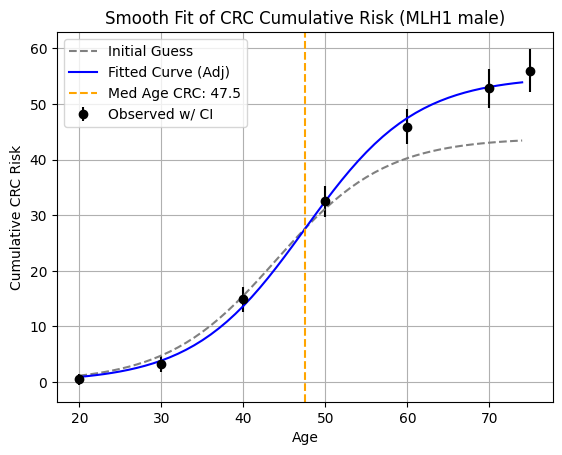

Median age of CRC presentation (inflection point): 55.0
Cumulative risk (age 75): 44.8


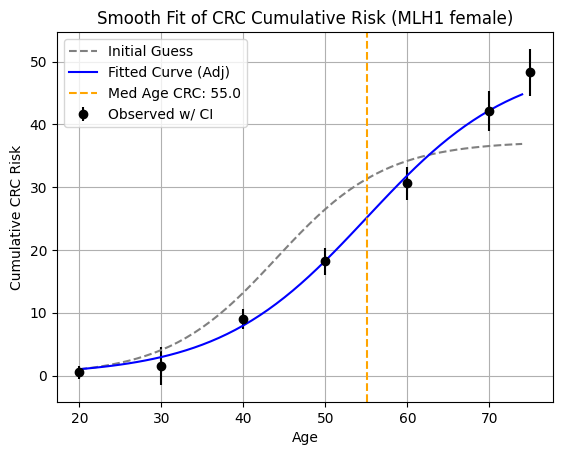

Median age of CRC presentation (inflection point): 55.0
Cumulative risk (age 75): 54.5


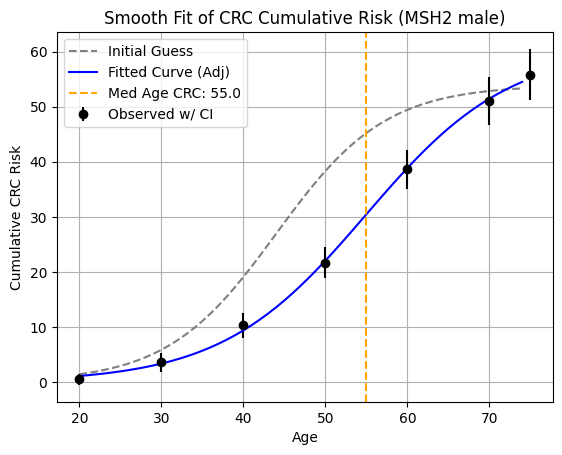

Median age of CRC presentation (inflection point): 59.5
Cumulative risk (age 75): 42.0


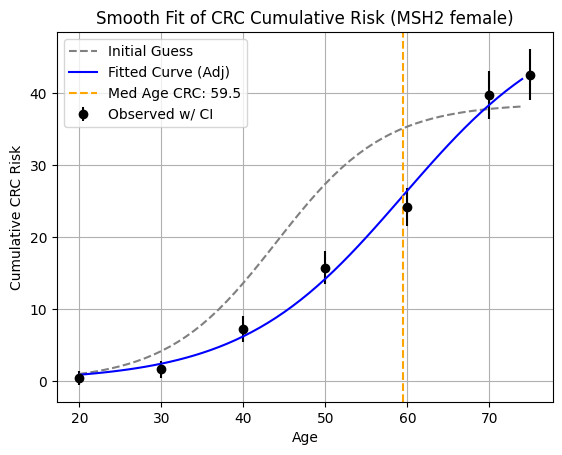

Median age of CRC presentation (inflection point): 51.4
Cumulative risk (age 75): 15.1


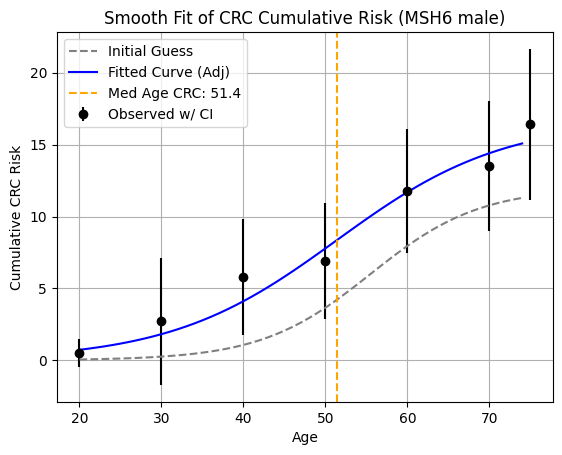

Median age of CRC presentation (inflection point): 60.0
Cumulative risk (age 75): 17.2


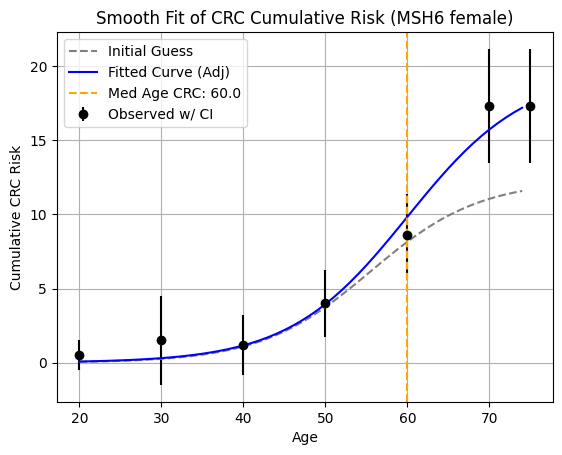

Median age of CRC presentation (inflection point): 67.0
Cumulative risk (age 75): 17.6


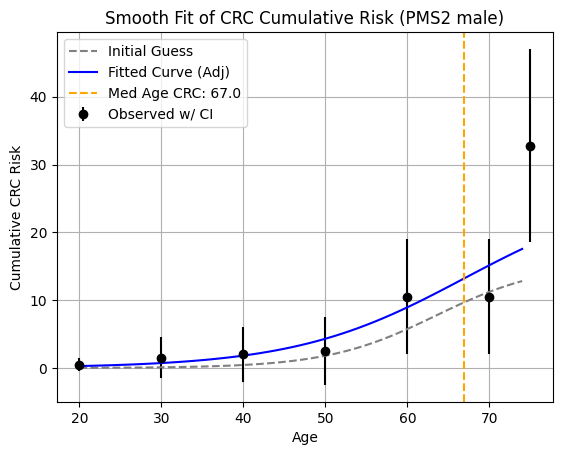

Median age of CRC presentation (inflection point): 75.0
Cumulative risk (age 75): 8.1


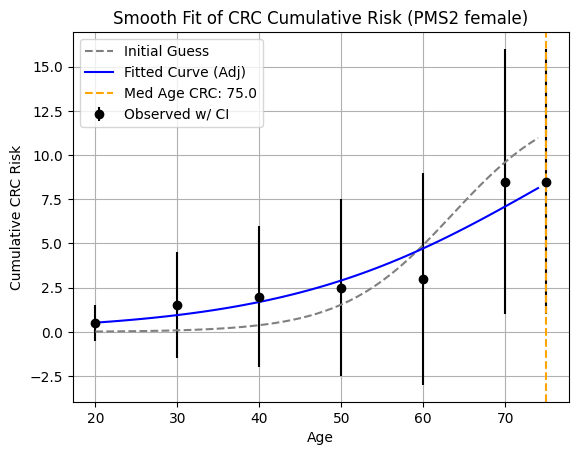

In [41]:
from itertools import product

risk_fit_dict = {}

for gene, sex in product(genes, sexes):
    if gene=='PMS2':
        risk_fit_dict[gene]= {f"{sex}": plot_logistic(sex,gene,50,75)}
    else:
        risk_fit_dict[gene] = {f"{sex}": plot_logistic(sex,gene,40,60)}